# GAN - CIFAR
Train the GAN model on the CIFAR dataset, and evaluate

In [11]:
# Load the Datasets
import torch
from torchvision import datasets, transforms, utils
import torchvision.utils as vutils
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Use GPU as the device if possible
default_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(default_device)

cuda


In [12]:
default_batch_size = 64

In [13]:
# LOAD CIFAR 10
# Cifar transform to preprocess the data
transcform_cifar_norm = transforms.Normalize((0.5,0.5, 0.5),(0.5, 0.5, 0.5)).to(default_device)
transform_cifar = transforms.Compose([transforms.ToTensor(), 
                                      transcform_cifar_norm])

# Download and load the training data
trainset_cifar = datasets.CIFAR10('./data/CIFAR10_data/', download=True, train=True, transform=transform_cifar)
trainloader_cifar = torch.utils.data.DataLoader(trainset_cifar, batch_size=default_batch_size, shuffle=True)

# Download and load the test data
testset_cifar = datasets.CIFAR10('./data/CIFAR10_data/', download=True, train=False, transform=transform_cifar)
testloader_cifar = torch.utils.data.DataLoader(testset_cifar, batch_size=default_batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
# DC GAN
class Generator(nn.Module):
    def __init__(self, z_dim, feature_size, channels_img):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(z_dim, feature_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.ReLU(True),
            # state size. ``(feature_size*8) x 4 x 4``
            nn.ConvTranspose2d(feature_size * 8, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( feature_size * 4, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( feature_size * 2, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( feature_size, channels_img, 3, 1, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        ).to(default_device)
    
    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, feature_size=64, channels_img=3):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(channels_img, feature_size, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(feature_size * 2, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(feature_size * 4, feature_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(feature_size * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        ).to(default_device)

    def forward(self, input):
        return self.main(input)

In [15]:
# CIFAR 10 Data Training - Conv
input_size = 32 * 32 * 3 # Size of CIFAR images - 3072
num_epochs = 1 # Number of epochs to train for

z_dim = 256 # Size of the latent vector [64, 256]
hidden_dim_feature_map = 64 # Size of the image (feature maps) at the last layer of the generator and first layer of the discriminator
lr = 0.0002
batch_size = 64
num_epochs = 15
img_channels = 3

In [16]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def training_loop_gan(generator, discriminator, optimG, optimD, img_channels=3, dataset=trainloader_cifar):
    # Training Loop
    # Hyperparameters
    img_channels = img_channels

    # Initialize the ``BCELoss`` function
    criterion = nn.BCELoss()

    # Create batch of latent vectors that we will use to visualize
    #  the progression of the generator
    fixed_noise = torch.randn(64, z_dim, 1, 1, device=default_device)

    # Establish convention for real and fake labels during training
    real_label = 1.
    fake_label = 0.

    # Setup Adam optimizers for both G and D
    optimizerD = optimD
    optimizerG = optimG

    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_losses = []
    jsd_list = []
    iters = 0

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataset, 0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            discriminator.zero_grad()
            # Format batch
            real_cpu = data[0].to(default_device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=default_device)
            # Forward pass real batch through D
            output = discriminator(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, z_dim, 1, 1, device=default_device)
            # Generate fake image batch with G
            fake = generator(noise)
            #label.fill_(fake_label)

            label = torch.full((b_size,), fake_label, dtype=torch.float, device=default_device)

            # Classify all fake batch with D
            output = discriminator(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            generator.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = discriminator(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Compute JSD
            JSD = D_x - 0.5 * (D_G_z1 + D_G_z2)
            jsd_list.append(JSD)

            # Output training stats
            if i % 1000 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tJSD: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(dataset),
                        errD.item(), errG.item(), D_x, JSD, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataset)-1)):
                with torch.no_grad():
                    fake = generator(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1
    return img_list, G_losses, D_losses, jsd_list 

In [17]:
# Create the generator and discriminator and apply the weights_init function
generator_cifar = Generator(z_dim, hidden_dim_feature_map, img_channels).to(default_device)
generator_cifar.apply(weights_init)
discriminator_cifar = Discriminator(hidden_dim_feature_map, img_channels)
discriminator_cifar.apply(weights_init)

optimizerD_cifar = optim.Adam(discriminator_cifar.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG_cifar = optim.Adam(generator_cifar.parameters(), lr=lr, betas=(0.5, 0.999))

img_list, G_losses, D_losses, jsd_list = training_loop_gan(generator_cifar, discriminator_cifar, optimizerG_cifar, optimizerD_cifar, img_channels=3, dataset=trainloader_cifar)

Starting Training Loop...
[0/15][0/782]	Loss_D: 1.8517	Loss_G: 4.0760	JSD: 0.3540	D(x): 0.1394	D(G(z)): 0.4080 / 0.0212
[1/15][0/782]	Loss_D: 0.5041	Loss_G: 3.5658	JSD: 0.8860	D(x): 0.7288	D(G(z)): 0.2750 / 0.0394
[2/15][0/782]	Loss_D: 0.4669	Loss_G: 4.8279	JSD: 0.8813	D(x): 0.7534	D(G(z)): 0.2416 / 0.0141
[3/15][0/782]	Loss_D: 0.1992	Loss_G: 4.2071	JSD: 0.9082	D(x): 0.8528	D(G(z)): 0.0853 / 0.0255
[4/15][0/782]	Loss_D: 0.9870	Loss_G: 4.5715	JSD: 0.9181	D(x): 0.6563	D(G(z)): 0.5038 / 0.0199
[5/15][0/782]	Loss_D: 1.1814	Loss_G: 5.0615	JSD: 0.9639	D(x): 0.6620	D(G(z)): 0.5931 / 0.0108
[6/15][0/782]	Loss_D: 0.5409	Loss_G: 4.3832	JSD: 0.8787	D(x): 0.7259	D(G(z)): 0.2882 / 0.0175
[7/15][0/782]	Loss_D: 0.6219	Loss_G: 2.3178	JSD: 0.8005	D(x): 0.6168	D(G(z)): 0.2349 / 0.1323
[8/15][0/782]	Loss_D: 0.4933	Loss_G: 6.1177	JSD: 0.9663	D(x): 0.8007	D(G(z)): 0.3279 / 0.0033
[9/15][0/782]	Loss_D: 1.0564	Loss_G: 4.7158	JSD: 0.9651	D(x): 0.6892	D(G(z)): 0.5349 / 0.0167
[10/15][0/782]	Loss_D: 0.2225	Loss

# Plot the Results

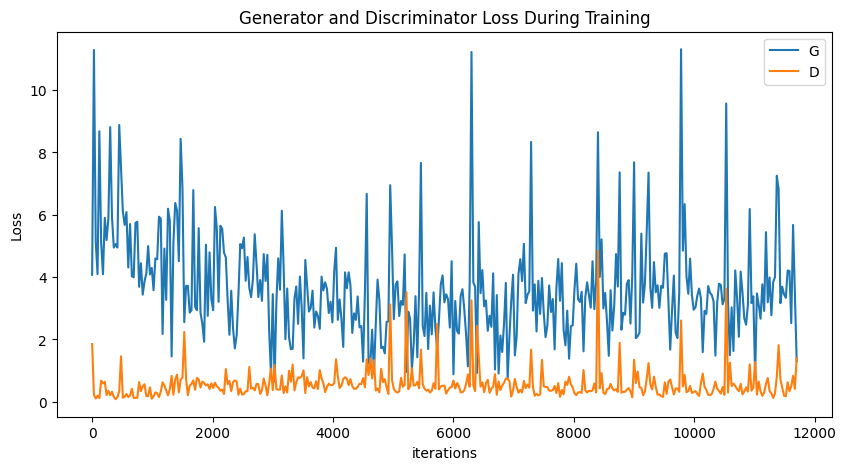

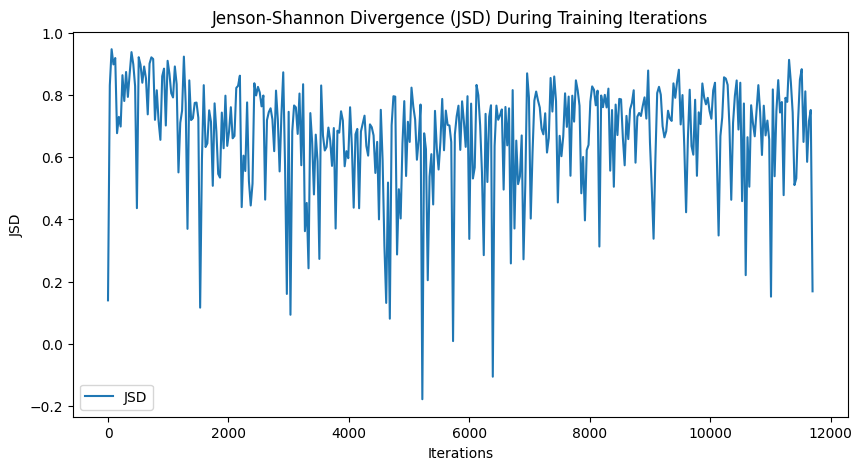

In [20]:
plot_every = 30

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(range(0, len(G_losses), plot_every), G_losses[::plot_every],label="G")
plt.plot(range(0, len(D_losses), plot_every), D_losses[::plot_every],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Jenson-Shannon Divergence (JSD) During Training Iterations")
plt.plot(range(0, len(jsd_list), plot_every), jsd_list[::plot_every],label="JSD")
plt.xlabel("Iterations")
plt.ylabel("JSD")
plt.legend()
plt.show()

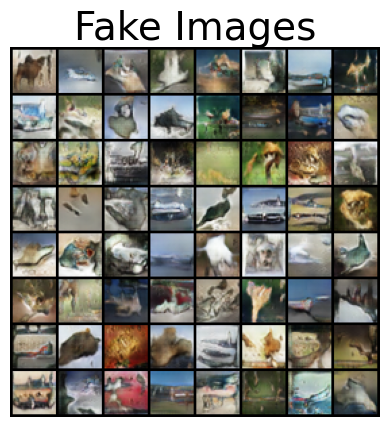

In [19]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(testloader_cifar))

# Plot the real images
# plt.figure(figsize=(15,15))
# plt.subplot(1,2,1)
# plt.axis("off")
# plt.title("Real Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(default_device)[:64], padding=3, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
# plt.subplot(1,2,2)
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Fake Images", fontsize=28)
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()